In [1]:
import sys
sys.path.append("../../") # gruppe_3 als lib dir

# ----------------------------------------------------------------------------------------
# VORSICHT: Änderungen an gruppe_3 - Files erfordern womöglich einen Jupyter-Neustart
# ----------------------------------------------------------------------------------------
import os
from sklearn.model_selection import train_test_split
from gruppe_3.dataset import DatasetReader, InputMode

estimators_dir = "estimators/"
classifiers_dir = estimators_dir+ "classifiers/"

# ----------------------------------------------------------------------------------------
# werden die Parameter nach dem InputMode weggelassen, so werden alle Dateien im Ziel-
# verzeichnis gelesen. Letzteres wird durch eine Umgebungsvariable adressiert, damit
# alle entspannt ins Git pushen können.
# ----------------------------------------------------------------------------------------

dataset_reader = DatasetReader(
    os.environ.get('EXTRA_SENSORY_DATASET'),
    InputMode.users
)

X, y = dataset_reader.read()

D:\Cache\ExtraSensory.per_uuid_features_labels\00EABED2-271D-49D8-B599-1D4A09240601.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\098A72A5-E3E5-4F54-A152-BBDA0DF7B694.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\0BFC35E2-4817-4865-BFA7-764742302A2D.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\0E6184E1-90C0-48EE-B25A-F1ECB7B9714E.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\1155FF54-63D3-4AB2-9863-8385D0BD0A13.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\11B5EC4D-4133-4289-B475-4E737182A406.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\136562B6-95B2-483D-88DC-065F28409FD2.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\1538C99F-BA1E-4EFB-A949-6C7C47701B20.features_labels.csv
D:\Cache\ExtraSensory.per_uuid_features_labels\1DBB0F6F-1F81-4A5

In [2]:
# ----------------------------------------------------------------------------------------
# Training-, Test- und Validation-DataFrame erzeugen
# ----------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Weitere Metadaten für den Catboost-Classifier festhalten
cat_features = [X.columns.get_loc(f) for f in dataset_reader.discrete_group_names]
num_features = [col for col in X.columns if col not in dataset_reader.discrete_group_names]

In [3]:
# ----------------------------------------------------------------------------------------
# Allgemeiner Kram, der in diversen Zellen benötigt wird
# ----------------------------------------------------------------------------------------
import dill
import errno
import re
import gruppe_3.constants as const
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from gruppe_3.label_transform import proba_to_label
%matplotlib inline

def write_output(file_content, file_name):
    print("Schreibe Datei: " + file_name)
    if not os.path.exists(os.path.dirname(file_name)):
        try:
            os.makedirs(os.path.dirname(file_name))
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise
    dill.dump(file_content, open(file_name, "wb"))
    
def get_feature_importance(X_test, y_test, cat_features, classifier):
    return pd.Series(classifier.get_feature_importance(Pool(X_test, label=y_test, cat_features=cat_features)),index=X_test.columns,name="importance")

def create_feature_importance_plot(importance_series):
    plt.rcParams["figure.figsize"] = [300, 30]
    return importance_series.plot.bar(y="importance",rot=90)

def plot_feature_importance(X_test, y_test, cat_features, classifier):
    importance=get_feature_importance(X_test, y_test, cat_features, classifier)
    return create_feature_importance_plot(importance)

def append_probabilities(X, probabilities, proba_prefix):
    X.reset_index(drop=True, inplace=True)
    probabilities.reset_index(drop=True, inplace=True)
    return pd.concat([X, probabilities], axis=1)

def create_proba_prefix(name):
    return "proba:" + name + "_"

def extract_name(label_name):
    return re.search("^label:(.*)$", label_name).group(1)
    
def perform_incremental_classification(X_train, X_val, X_test, y_test, classifier, name, binary=False):
    proba_prefix = create_proba_prefix(name)
    
    if binary:
        y_test_pred_proba = classifier.predict_proba(X_test)[:,1]
    else:
        y_test_pred_proba = classifier.predict_proba(X_test)
    y_test_pred_proba =  pd.DataFrame(y_test_pred_proba, index=X_test.index).add_prefix(proba_prefix).fillna(0)
    y_pred = proba_to_label(y_test_pred_proba, proba_prefix)
    X_test = append_probabilities(X_test, y_test_pred_proba, proba_prefix)
    print("accuracy-score for " + name + ": " + str(accuracy_score(y_test, y_pred)))
    print("balanced-accuracy-score for " + name + ": " + str(balanced_accuracy_score(y_test, y_pred)))
    
    if binary:
        y_train_pred_proba = classifier.predict_proba(X_train)[:,1]
    else:
        y_train_pred_proba = classifier.predict_proba(X_train)
    y_train_pred_proba =  pd.DataFrame(y_train_pred_proba, index=X_train.index).add_prefix(proba_prefix).fillna(0)
    X_train = append_probabilities(X_train, y_train_pred_proba, proba_prefix)

    if binary:
        y_val_pred_proba = classifier.predict_proba(X_val)[:,1]
    else:
        y_val_pred_proba = classifier.predict_proba(X_val)
    y_val_pred_proba =  pd.DataFrame(y_val_pred_proba, index=X_val.index).add_prefix(proba_prefix).fillna(0)
    X_val = append_probabilities(X_val, y_val_pred_proba, proba_prefix)
    
    return (X_train, X_val, X_test)

In [4]:
# ----------------------------------------------------------------------------------------
# NACH DEM STATISCHEN DATA PREPROCESSING NUN DAS DYNAMISCHE
# ----------------------------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler())
])

X_train[num_features] = pd.DataFrame(preprocessor.fit_transform(X_train[num_features]), index=X_train.index, columns=num_features)
X_val[num_features] = pd.DataFrame(preprocessor.transform(X_val[num_features]), index=X_val.index, columns=num_features)
X_test[num_features] = pd.DataFrame(preprocessor.transform(X_test[num_features]), index=X_test.index, columns=num_features)

d:\programme\entwicklung\git\extra-sensory\extra-sensory-notebooks\venv\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [5]:
# ----------------------------------------------------------------------------------------
# USER CLASSIFIER AUS DATEI EINLESEN
# ----------------------------------------------------------------------------------------
user_classifier = dill.load(open(classifiers_dir+"user_classifier.sav", "rb"))

In [5]:
# ----------------------------------------------------------------------------------------
# USER CLASSIFIER TRAINIEREN UND SPEICHERN
# ----------------------------------------------------------------------------------------
from catboost import CatBoostClassifier, Pool

user_classifier = CatBoostClassifier(
                        task_type="GPU",
                        random_state=42,
                        depth=7,
                        iterations=1500,
                        loss_function="MultiClass",
                        l2_leaf_reg=4.0,
                        early_stopping_rounds=10,
                        verbose=100)

user_classifier = user_classifier.fit(X_train, y_train[const.user_id_label_name], 
    cat_features=cat_features,
    eval_set=Pool(X_val, y_val[const.user_id_label_name],cat_features=cat_features),
    verbose_eval=100
)

write_output(user_classifier, classifiers_dir + "user_classifier.sav")

0:	learn: -3.5130101	test: -3.5146892	best: -3.5146892 (0)	total: 372ms	remaining: 9m 16s
100:	learn: -0.4562835	test: -0.4562978	best: -0.4562978 (100)	total: 35.9s	remaining: 8m 16s
200:	learn: -0.1996922	test: -0.2015990	best: -0.2015990 (200)	total: 1m 11s	remaining: 7m 41s
300:	learn: -0.1164769	test: -0.1198290	best: -0.1198290 (300)	total: 1m 47s	remaining: 7m 6s
400:	learn: -0.0771983	test: -0.0812888	best: -0.0812888 (400)	total: 2m 23s	remaining: 6m 33s
500:	learn: -0.0580899	test: -0.0626522	best: -0.0626522 (500)	total: 2m 59s	remaining: 5m 57s
600:	learn: -0.0472614	test: -0.0520803	best: -0.0520803 (600)	total: 3m 34s	remaining: 5m 20s
700:	learn: -0.0402844	test: -0.0453346	best: -0.0453346 (700)	total: 4m 7s	remaining: 4m 42s
800:	learn: -0.0355365	test: -0.0407378	best: -0.0407378 (800)	total: 4m 40s	remaining: 4m 5s
900:	learn: -0.0321434	test: -0.0374565	best: -0.0374565 (900)	total: 5m 13s	remaining: 3m 28s
1000:	learn: -0.0297125	test: -0.0352184	best: -0.0352184 (

accuracy-score for user: 0.9957069034053266
balanced-accuracy-score for user: 0.995634442694422


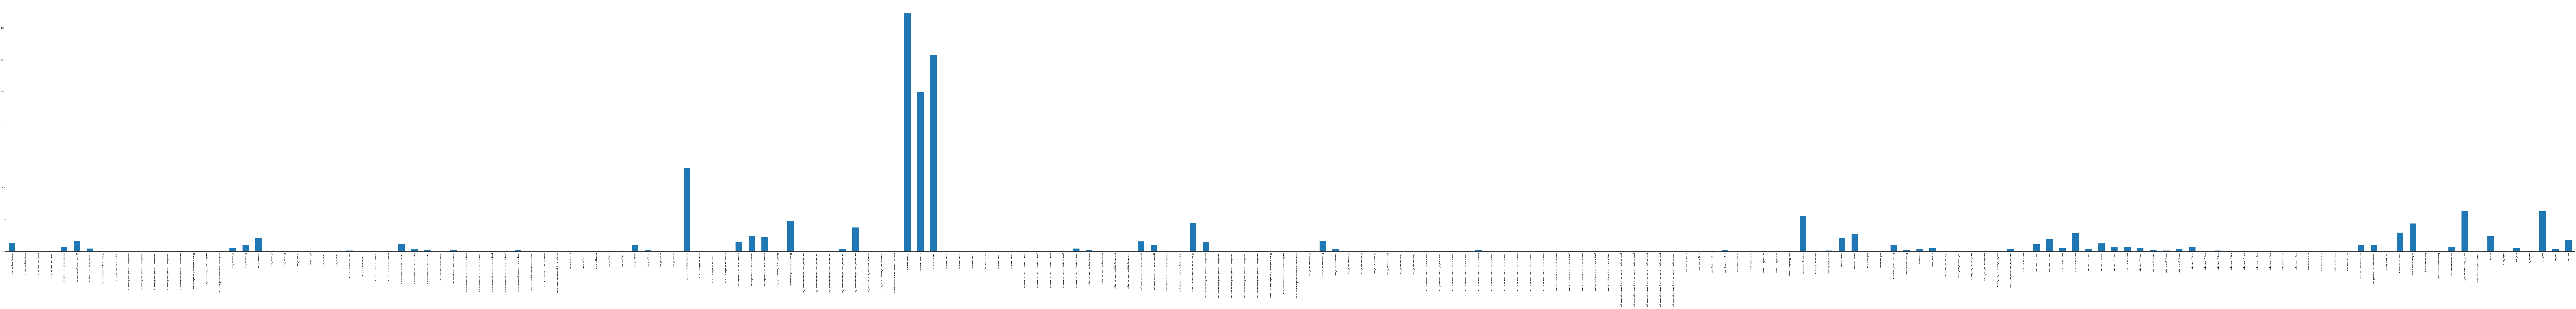

In [6]:
# Wahrscheinlichkeiten für User an bisherige Features anhängen und Feature Importance plotten
user_feature_importance = plot_feature_importance(X_test, y_test[const.user_id_label_name], cat_features, user_classifier)
X_train, X_val, X_test = perform_incremental_classification(
    X_train, X_val, X_test, 
    y_test[const.user_id_label_name], user_classifier, extract_name(const.user_id_label_name))
user_feature_importance

In [7]:
# ----------------------------------------------------------------------------------------
# MAIN ACTIVITY CLASSIFIER AUS DATEI EINLESEN
# ----------------------------------------------------------------------------------------
main_activity_classifier = dill.load(open(classifiers_dir + "main_activity_classifier.sav", "rb"))

In [ ]:
# ----------------------------------------------------------------------------------------
# MAIN ACTIVITY CLASSIFIER TRAINIEREN UND SPEICHERN
# ----------------------------------------------------------------------------------------
from catboost import CatBoostClassifier, Pool

main_activity_classifier = CatBoostClassifier(
                        task_type="GPU",
                        random_state=42,
                        depth=9,
                        iterations=6000,
                        loss_function="MultiClass",
                        l2_leaf_reg=2.5,
                        early_stopping_rounds=100,
                        verbose=100)

main_activity_classifier = main_activity_classifier.fit(X_train, y_train[const.main_activity_label_name], 
    cat_features=cat_features,
    eval_set=Pool(X_val, y_val[const.main_activity_label_name],cat_features=cat_features),
    verbose_eval=100
)
dill.dump(main_activity_classifier, open(classifiers_dir+"main_activity_classifier.sav", "wb"))

accuracy-score for main_activity: 0.9070624089042003
balanced-accuracy-score for main_activity: 0.8511234248005936


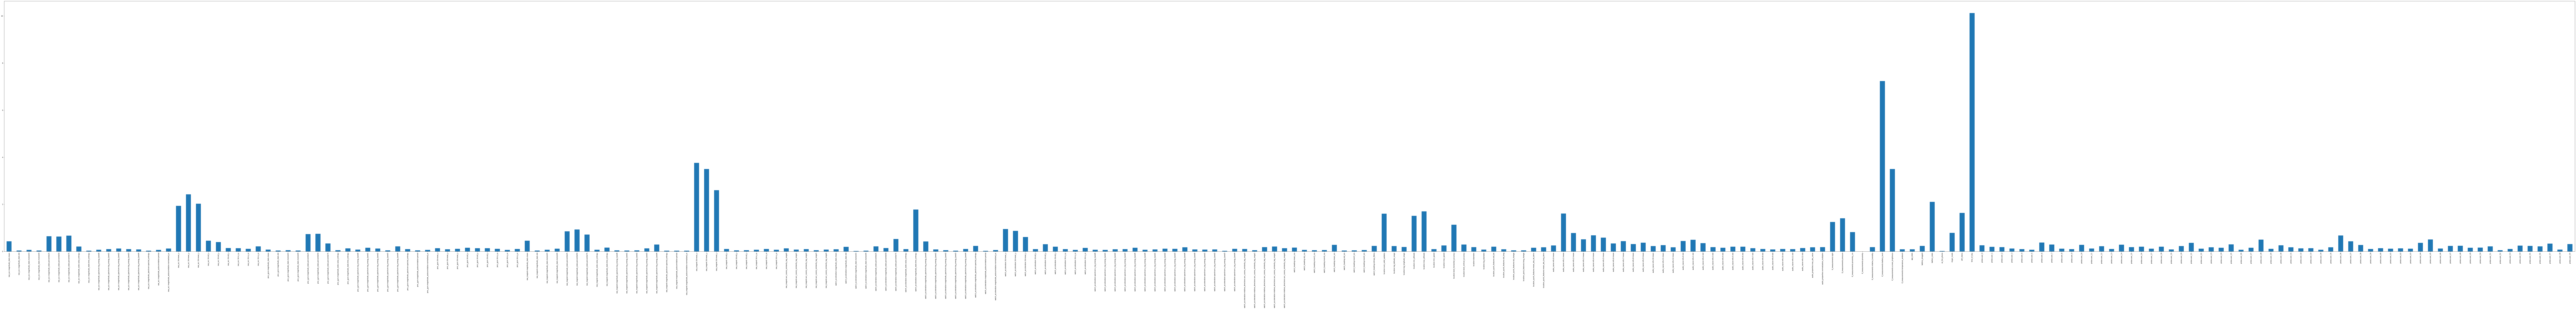

In [8]:
# Wahrscheinlichkeiten für Main-Activities an bisherige Features anhängen und Feature Importance plotten
main_activity_feature_importance = plot_feature_importance(X_test, y_test[const.main_activity_label_name], cat_features, main_activity_classifier)
X_train, X_val, X_test = perform_incremental_classification(
    X_train, X_val, X_test, 
    y_test[const.main_activity_label_name], main_activity_classifier, extract_name(const.main_activity_label_name))
main_activity_feature_importance


In [9]:
# ----------------------------------------------------------------------------------------
# VARIOUS-A CLASSIFIER AUS DATEI EINLESEN
# ----------------------------------------------------------------------------------------
various_a_classifier = dill.load(open(classifiers_dir+"various_a_classifier.sav", "rb"))

In [ ]:
# ----------------------------------------------------------------------------------------
# VARIOUS-A CLASSIFIER TRAINIEREN UND SPEICHERN
# ----------------------------------------------------------------------------------------
various_a_classifier = CatBoostClassifier(
    verbose=100,
    task_type="GPU",
    iterations=5000,
    early_stopping_rounds=100,
    l2_leaf_reg=3.0,
    loss_function = "MultiClass",
    depth = 6
)

various_a_classifier = various_a_classifier.fit(X_train, y_train[const.various_a_label_name], 
    cat_features=cat_features,
    eval_set=Pool(X_val, y_val[const.various_a_label_name],cat_features=cat_features),
    verbose_eval=100
)
write_output(various_a_classifier, classifiers_dir + "various_a_classifier.sav")

accuracy-score for various_a: 0.9796342917715649
balanced-accuracy-score for various_a: 0.7808757393452704


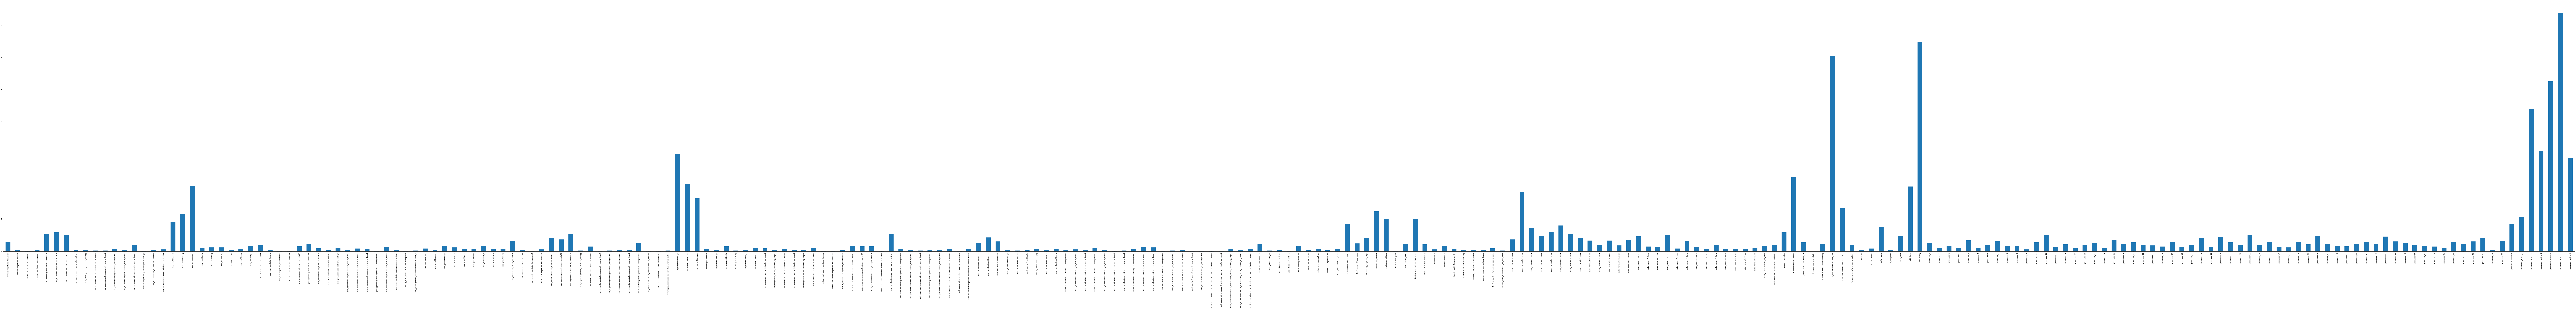

In [10]:
# Wahrscheinlichkeiten für Various-A an bisherige Features anhängen
various_a_feature_importance = plot_feature_importance(X_test, y_test[const.various_a_label_name], cat_features, various_a_classifier)
X_train, X_val, X_test = perform_incremental_classification(
    X_train, X_val, X_test, 
    y_test[const.various_a_label_name], various_a_classifier, extract_name(const.various_a_label_name))
various_a_feature_importance

In [11]:
# ----------------------------------------------------------------------------------------
# VARIOUS-B CLASSIFIER AUS DATEI EINLESEN
# ----------------------------------------------------------------------------------------
various_b_classifier = dill.load(open(classifiers_dir+"various_b_classifier.sav", "rb"))

In [ ]:
# ----------------------------------------------------------------------------------------
# VARIOUS-B CLASSIFIER TRAINIEREN UND SPEICHERN
# ----------------------------------------------------------------------------------------
various_b_classifier = CatBoostClassifier(
        verbose=100,
        task_type="GPU",
        iterations=5000,
        early_stopping_rounds=100,
        l2_leaf_reg=3.0,
        loss_function = "MultiClass",
        depth = 6
)

various_b_classifier = various_b_classifier.fit(X_train, y_train[const.various_b_label_name], 
    cat_features=cat_features,
    eval_set=Pool(X_val, y_val[const.various_b_label_name],cat_features=cat_features),
    verbose_eval=100
)
write_output(various_b_classifier, classifiers_dir + "various_b_classifier.sav")

accuracy-score for various_b: 0.9658407314164569
balanced-accuracy-score for various_b: 0.7772317671101506


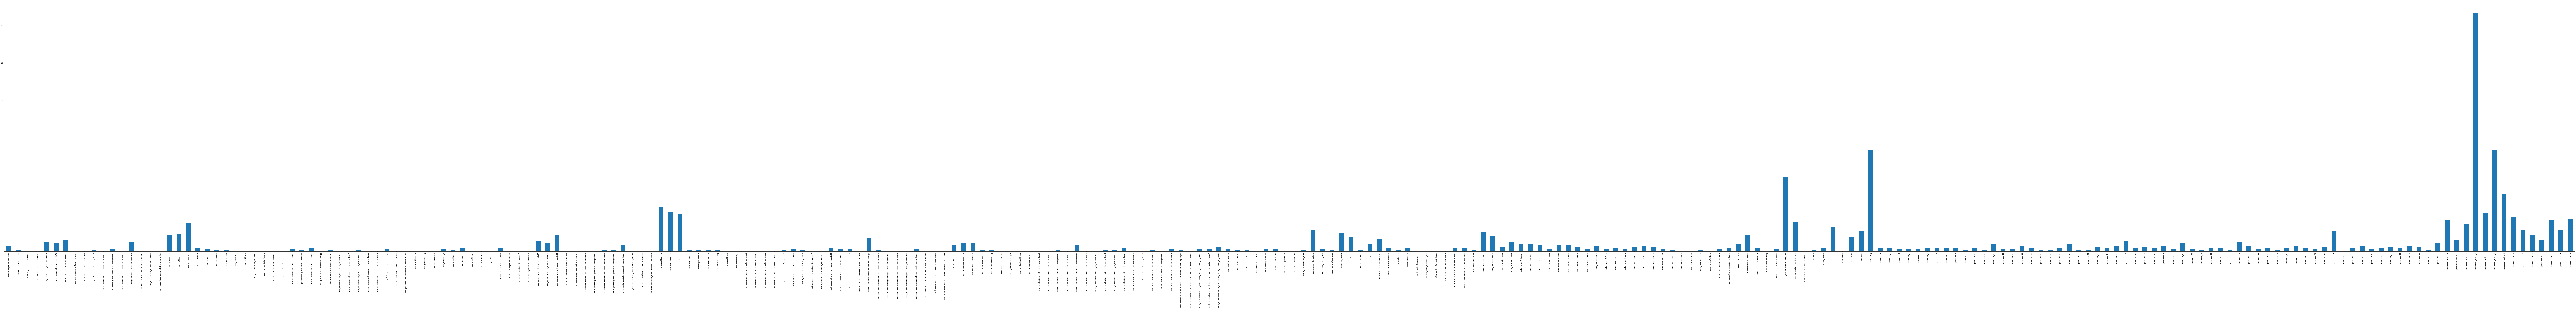

In [12]:
# Wahrscheinlichkeiten für Various-A an bisherige Features anhängen
various_b_feature_importance = plot_feature_importance(X_test, y_test[const.various_b_label_name], cat_features, various_b_classifier)
X_train, X_val, X_test = perform_incremental_classification(
    X_train, X_val, X_test, 
    y_test[const.various_b_label_name], various_b_classifier, extract_name(const.various_b_label_name))
various_b_feature_importance

In [13]:
# ----------------------------------------------------------------------------------------
# PHONE CLASSIFIER AUS DATEI EINLESEN
# ----------------------------------------------------------------------------------------
phone_classifier = dill.load(open(classifiers_dir+"phone_classifier.sav", "rb"))

In [ ]:
# ----------------------------------------------------------------------------------------
# PHONE CLASSIFIER TRAINIEREN UND SPEICHERN
# ----------------------------------------------------------------------------------------
phone_classifier = CatBoostClassifier(
        verbose=100,
        task_type="GPU",
        iterations=5000,
        l2_leaf_reg=3.0,
        loss_function = "MultiClass",
        early_stopping_rounds=100,
        depth = 6,
        random_state=42
)

phone_classifier = phone_classifier.fit(X_train, y_train[const.phone_label_name], 
    cat_features=cat_features,
    eval_set=Pool(X_val, y_val[const.phone_label_name],cat_features=cat_features),
    verbose_eval=100
)
write_output(phone_classifier, classifiers_dir + "phone_classifier.sav")

accuracy-score for phone: 0.9218497416191864
balanced-accuracy-score for phone: 0.8354342960504519


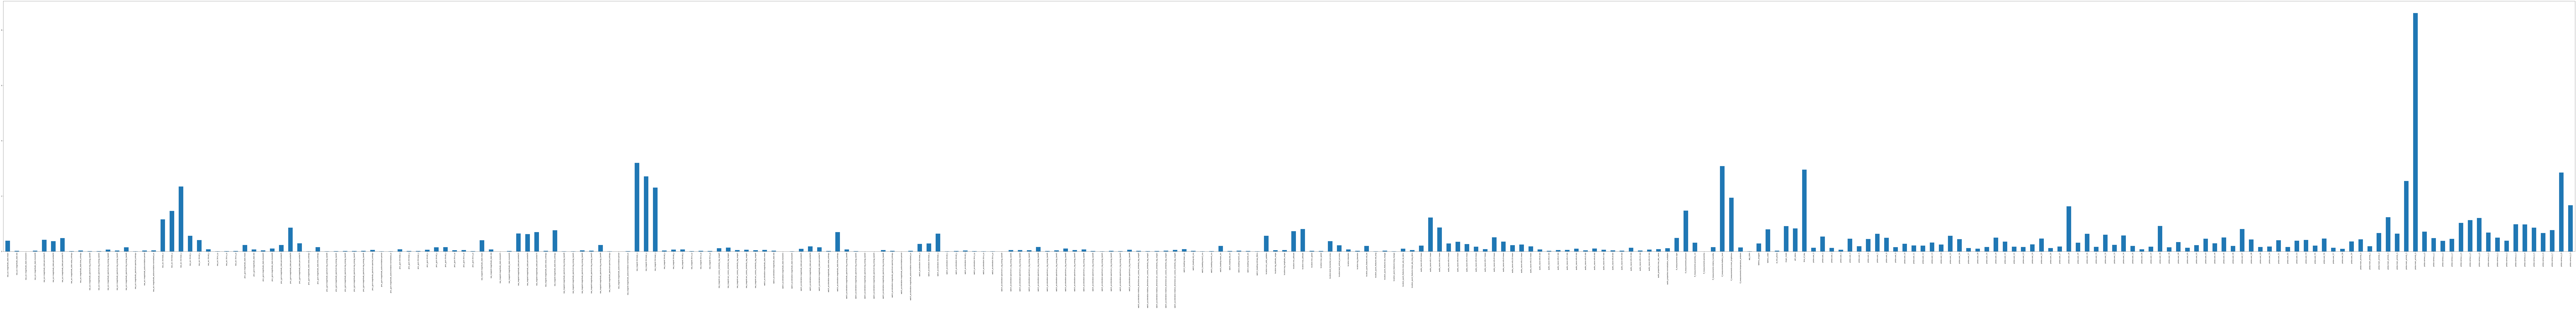

In [14]:
# Wahrscheinlichkeiten für Various-A an bisherige Features anhängen
phone_feature_importance = plot_feature_importance(X_test, y_test[const.phone_label_name], cat_features, phone_classifier)
X_train, X_val, X_test = perform_incremental_classification(
    X_train, X_val, X_test, 
    y_test[const.phone_label_name], phone_classifier, extract_name(const.phone_label_name))
phone_feature_importance

In [15]:
# ----------------------------------------------------------------------------------------
# EINE OPTIONALE MENGE DER GENERISCH ERZEUGTEN CLASSIFIER ANHAND DER LABEL-NAMEN LADEN
# ----------------------------------------------------------------------------------------
load_classifiers_for_label_names = [c for c in y_train.columns if c not in [
    const.user_id_label_name,
    const.main_activity_label_name,
    const.various_a_label_name,
    const.various_b_label_name,
    const.phone_label_name
]]

In [16]:
# ----------------------------------------------------------------------------------------
# ALLE RESTLICHEN LABELS MIT JEWEILS EINEM MODELL TRAINIEREN UND SPEICHERN
# ----------------------------------------------------------------------------------------
import re

if "load_classifiers_for_label_names" not in locals():
    load_classifiers_for_label_names = []

remaining_label_names = [c for c in y_train.columns if c not in [
    const.user_id_label_name,
    const.main_activity_label_name,
    const.various_a_label_name,
    const.various_b_label_name,
    const.phone_label_name
]]

remaining_feature_importances = dict()

for remaining_label_name in remaining_label_names:
    remaining_label_name_cut = extract_name(remaining_label_name)
    remaining_classifier_file_name = classifiers_dir + remaining_label_name_cut + "_classifier.sav"
    
    if remaining_label_name in load_classifiers_for_label_names:
        remaining_classifier = dill.load(open(remaining_classifier_file_name, "rb"))
    else:
        remaining_classifier = CatBoostClassifier(
                verbose=100,
                task_type="GPU",
                iterations=1200,
                depth = 6,
                random_state=42,
                l2_leaf_reg=3.5,
                early_stopping_rounds=100
        )
        remaining_classifier = remaining_classifier.fit(X_train, y_train[remaining_label_name], 
            cat_features=cat_features,
            eval_set=Pool(X_val, y_val[remaining_label_name],cat_features=cat_features),
            verbose_eval=100
        )
        write_output(phone_classifier, remaining_classifier_file_name)
        
    remaining_feature_importances[remaining_label_name] = get_feature_importance(X_test, y_test[remaining_label_name], cat_features, remaining_classifier)
    X_train, X_val, X_test = perform_incremental_classification(
        X_train, X_val, X_test, 
        y_test[remaining_label_name], remaining_classifier, remaining_label_name_cut)

accuracy-score for LOC_main_workplace: 0.9865509473963164
balanced-accuracy-score for LOC_main_workplace: 0.9518598520759245
accuracy-score for OR_indoors: 0.9467470518086657
balanced-accuracy-score for OR_indoors: 0.9466875839249214
accuracy-score for ON_A_BUS: 0.9964091692063072
balanced-accuracy-score for ON_A_BUS: 0.6974776504544118
accuracy-score for DRIVE_-_I_M_THE_DRIVER: 0.992831588710746
balanced-accuracy-score for DRIVE_-_I_M_THE_DRIVER: 0.8754708986041241
accuracy-score for DRIVE_-_I_M_A_PASSENGER: 0.9971511859016828
balanced-accuracy-score for DRIVE_-_I_M_A_PASSENGER: 0.8458546724096682
accuracy-score for LOC_home: 0.9583808135683053
balanced-accuracy-score for LOC_home: 0.9583726458704046
accuracy-score for SHOPPING: 0.9973764409699218
balanced-accuracy-score for SHOPPING: 0.7721380942876594
accuracy-score for STROLLING: 0.9989267258513317
balanced-accuracy-score for STROLLING: 0.8041106314133619
accuracy-score for DRINKING__ALCOHOL_: 0.9990592288326487
balanced-accuracy-s

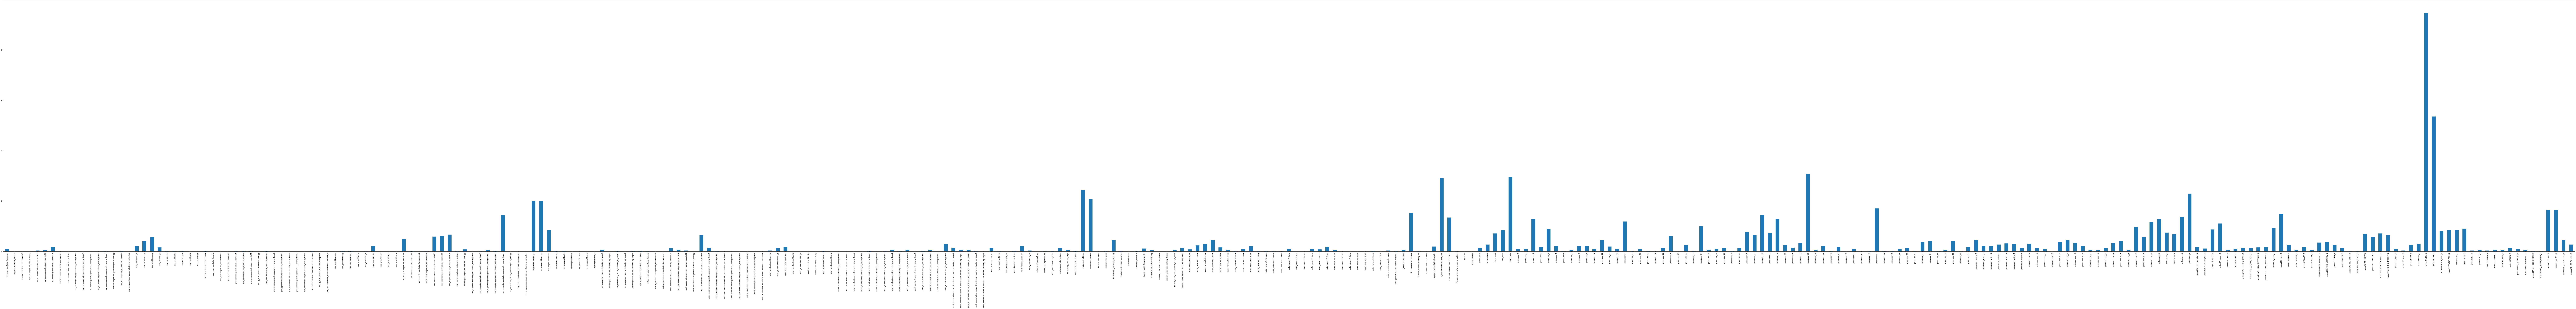

In [18]:
# Feature-Importance für ein spezifisches Label plotten (geht auch mit den anderen aus remaining_label_names)
create_feature_importance_plot(remaining_feature_importances["label:WITH_FRIENDS"])

In [39]:
# Um alle Wahrscheinlichkeiten angereicherte Features anzeigen (eine Zeile)
X_test.head(1)

raw_acc:magnitude_stats:mean  raw_acc:magnitude_stats:std  \
0                     -0.227885                    -0.391372   

   raw_acc:magnitude_stats:moment3  raw_acc:magnitude_stats:moment4  \
0                          -0.3298                        -0.417456   

   raw_acc:magnitude_stats:percentile25  raw_acc:magnitude_stats:percentile50  \
0                               0.00299                             -0.186886   

   raw_acc:magnitude_stats:percentile75  \
0                              -0.30343   

   raw_acc:magnitude_stats:value_entropy  \
0                               0.775279   

   raw_acc:magnitude_stats:time_entropy  \
0                              0.203865   

   raw_acc:magnitude_spectrum:log_energy_band0  ...  \
0                                     0.150016  ...   

   proba:STAIRS_-_GOING_UP_0  proba:STAIRS_-_GOING_UP_1  \
0                   0.999995                   0.000005   

   proba:STAIRS_-_GOING_DOWN_0  proba:STAIRS_-_GOING_DOWN_1  \
0                     0.999998                     0.000002   

   proba:AT_SCHOOL_0  proba:AT_SCHOOL_1  proba:WITH_CO-WORKERS_0  \
0           0.996628           0.003372                 0.999985   

   proba:WITH_CO-WORKERS_1  proba:WITH_FRIENDS_0  proba:WITH_FRIENDS_1  
0                 0.000015              0.998443              0.001557  

[1 rows x 339 columns]

In [81]:
# ----------------------------------------------------------------------------------------
# WAHRSCHEINLICHKEITEN AUS AGGREGIERTEN FEATURES EXTRAHIEREN
# ----------------------------------------------------------------------------------------
def extract_probas(X_with_probas, proba_prefix):
    proba_columns = [c for c in X_with_probas.columns if c.startswith(proba_prefix)]
    return X_with_probas[proba_columns]

# X_test enthält zu diesem Zeitpunkt alle vorhergesagten Wahrscheinlichkeiten
proba_dict = dict()
for proba_name in [extract_name(l) for l in const.aggregated_column_names + remaining_label_names]:
    proba_prefix = create_proba_prefix(proba_name)
    extracted_probas = extract_probas(X_test, proba_prefix)
    extracted_probas.columns = [c[len(proba_prefix):] for c in extracted_probas.columns]
    proba_dict["label:" + proba_name] = extracted_probas

# Einen Beispiel-Frame printen
proba_dict["label:main_activity"].head(3)

0             1         2         3         4         5  \
0  4.070510e-07  1.296788e-07  0.000469  0.990489  0.002200  0.006094   
1  3.019284e-05  1.658121e-04  0.211621  0.002879  0.225596  0.554948   
2  1.813993e-05  2.983490e-07  0.003799  0.001712  0.002720  0.931816   

          6  
0  0.000748  
1  0.004760  
2  0.059934

In [109]:
# ----------------------------------------------------------------------------------------
# Pandas 23+ reduce & expand für das performante inverse Transformieren verwenden...
# ----------------------------------------------------------------------------------------
y_out = pd.DataFrame(index=X_test.index)

def enc_transform(df, agg_label):
    if agg_label not in dataset_reader.encoders:
        return df[agg_label]
    enc = dataset_reader.encoders[agg_label]
    return enc.inverse_transform(df[agg_label])
    
def label_reduce(s):
    return int(s.idxmax(axis=1))

def multi_expand(s, agg_label, agg_none_label, agg_label_names):
        result = [0 for i in range(len(agg_label_names))]
        label = s[agg_label]
        if label != agg_none_label:
            idx_selected = agg_label_names.index(label)
            result[idx_selected] = 1
        return pd.Series(result)
    
def main_activity_expand(s):
    return multi_expand(s, const.main_activity_label_name, const.main_activity_missing_label_name, const.main_activity_label_names)

def various_a_expand(s):
    return multi_expand(s, const.various_a_label_name, const.various_a_missing_label_name, const.various_a_label_names)

def various_b_expand(s):
    return multi_expand(s, const.various_b_label_name, const.various_b_missing_label_name, const.various_b_label_names)

def phone_expand(s):
    return multi_expand(s, const.phone_label_name, const.phone_missing_label_name, const.phone_label_names)

def do_inv_transform(y_out, agg_label, agg_label_names=None, expand=None):
    y_out[agg_label] = proba_dict[agg_label].apply(label_reduce, axis=1, result_type="reduce")
    y_out[agg_label] = enc_transform(y_out, agg_label)
    if expand is None:
        return y_out
    y_out[agg_label_names] = y_out.apply(expand, axis=1, result_type="expand")
    return y_out.drop(columns=[agg_label])

for col_info in [
    (const.user_id_label_name, None, None),
    (const.main_activity_label_name, const.main_activity_label_names, main_activity_expand),
    (const.various_a_label_name, const.various_a_label_names, various_a_expand),
    (const.various_b_label_name, const.various_b_label_names, various_b_expand),
    (const.phone_label_name, const.phone_label_names, phone_expand)
] + [(col, None, None) for col in remaining_label_names]:
    print("inverse-transform " + col_info[0])
    y_out = do_inv_transform(y_out, col_info[0], col_info[1], col_info[2])
    
# Zum Schluss nochmal alles printen
y_out.head(3)

inverse-transform label:user
inverse-transform label:main_activity
inverse-transform label:various_a
inverse-transform label:various_b
inverse-transform label:phone
inverse-transform label:LOC_main_workplace
inverse-transform label:OR_indoors
inverse-transform label:ON_A_BUS
inverse-transform label:DRIVE_-_I_M_THE_DRIVER
inverse-transform label:DRIVE_-_I_M_A_PASSENGER
inverse-transform label:LOC_home
inverse-transform label:SHOPPING
inverse-transform label:STROLLING
inverse-transform label:DRINKING__ALCOHOL_
inverse-transform label:CLEANING
inverse-transform label:WASHING_DISHES
inverse-transform label:WATCHING_TV
inverse-transform label:SURFING_THE_INTERNET
inverse-transform label:LOC_beach
inverse-transform label:SINGING
inverse-transform label:TALKING
inverse-transform label:COMPUTER_WORK
inverse-transform label:EATING
inverse-transform label:TOILET
inverse-transform label:GROOMING
inverse-transform label:DRESSING
inverse-transform label:STAIRS_-_GOING_UP
inverse-transform label:STA

label:user  label:LYING_DOWN  label:SITTING  \
0  83CF687B-7CEC-434B-9FE8-00C3D5799BE6                 1              0   
1  0E6184E1-90C0-48EE-B25A-F1ECB7B9714E                 0              1   
2  99B204C0-DD5C-4BB7-83E8-A37281B8D769                 0              1   

   label:OR_standing  label:FIX_running  label:FIX_walking  label:BICYCLING  \
0                  0                  0                  0                0   
1                  0                  0                  0                0   
2                  0                  0                  0                0   

   label:IN_CLASS  label:OR_outside  label:BATHING_-_SHOWER  ...  \
0               0                 0                       0  ...   
1               0                 0                       0  ...   
2               0                 0                       0  ...   

   label:COMPUTER_WORK  label:EATING  label:TOILET  label:GROOMING  \
0                    0             0             0               0   
1                    0             1             0               0   
2                    1             0             0               0   

   label:DRESSING  label:STAIRS_-_GOING_UP  label:STAIRS_-_GOING_DOWN  \
0               0                        0                          0   
1               0                        0                          0   
2               0                        0                          0   

   label:AT_SCHOOL  label:WITH_CO-WORKERS  label:WITH_FRIENDS  
0                0                      0                   0  
1                0                      0                   1  
2                0                      0                   0  

[3 rows x 52 columns]

In [110]:
# Aufbereitete Label in .csv-Datei schreiben
y_out.to_csv("output.csv", sep=',')

In [111]:
# Aufbereitete Label aus .csv-Datei einlesen
y_out = pd.read_csv("output.csv", index_col=0, sep=',')

In [112]:
# Eine Zeile der aufbereiteten Ausgabe printen
y_out.head(3)


label:user  label:LYING_DOWN  label:SITTING  \
0  83CF687B-7CEC-434B-9FE8-00C3D5799BE6                 1              0   
1  0E6184E1-90C0-48EE-B25A-F1ECB7B9714E                 0              1   
2  99B204C0-DD5C-4BB7-83E8-A37281B8D769                 0              1   

   label:OR_standing  label:FIX_running  label:FIX_walking  label:BICYCLING  \
0                  0                  0                  0                0   
1                  0                  0                  0                0   
2                  0                  0                  0                0   

   label:IN_CLASS  label:OR_outside  label:BATHING_-_SHOWER  ...  \
0               0                 0                       0  ...   
1               0                 0                       0  ...   
2               0                 0                       0  ...   

   label:COMPUTER_WORK  label:EATING  label:TOILET  label:GROOMING  \
0                    0             0             0               0   
1                    0             1             0               0   
2                    1             0             0               0   

   label:DRESSING  label:STAIRS_-_GOING_UP  label:STAIRS_-_GOING_DOWN  \
0               0                        0                          0   
1               0                        0                          0   
2               0                        0                          0   

   label:AT_SCHOOL  label:WITH_CO-WORKERS  label:WITH_FRIENDS  
0                0                      0                   0  
1                0                      0                   1  
2                0                      0                   0  

[3 rows x 52 columns]